# Loading the libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import re
# Basic EDA, cleaning, and visualization modules

from bs4 import BeautifulSoup
from IPython.core.display import display, HTML
import requests
# Webscraping 

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error ,mean_absolute_error
import scipy.stats as stats
# Modeling

#from helper_functions.directors_to_list import directors_list, remove_paren
#from helper_functions.imdb_big_scrape import get_movie_links
#from helper_functions.getting_info import get_movie_data
# Functions I made in corresponding .py files

import pickle
%load_ext autoreload
%autoreload 2


import urllib
# packages that is used to work with URL libraries

import os 
from time import sleep
from random import randint
# package used for file process

requests.__version__ # check the version of the package

'2.25.1'

Scraping from the web page

In [2]:
# Creating the lists we want to write into
titles = []
years = []
time = []
Genres = []
imdb_ratings = []
votes = []
us_gross = []

In [3]:
# Getting English translated titles from the movies
headers = {'Accept-Language': 'en-US, en;q=0.5'}

In [4]:
pages = np.arange(1, 5001, 50)
pages

array([   1,   51,  101,  151,  201,  251,  301,  351,  401,  451,  501,
        551,  601,  651,  701,  751,  801,  851,  901,  951, 1001, 1051,
       1101, 1151, 1201, 1251, 1301, 1351, 1401, 1451, 1501, 1551, 1601,
       1651, 1701, 1751, 1801, 1851, 1901, 1951, 2001, 2051, 2101, 2151,
       2201, 2251, 2301, 2351, 2401, 2451, 2501, 2551, 2601, 2651, 2701,
       2751, 2801, 2851, 2901, 2951, 3001, 3051, 3101, 3151, 3201, 3251,
       3301, 3351, 3401, 3451, 3501, 3551, 3601, 3651, 3701, 3751, 3801,
       3851, 3901, 3951, 4001, 4051, 4101, 4151, 4201, 4251, 4301, 4351,
       4401, 4451, 4501, 4551, 4601, 4651, 4701, 4751, 4801, 4851, 4901,
       4951])

In [5]:
# Storing each of the urls of 50 movies 
for page in pages:
    # Getting the contents from the each url
    page = requests.get('https://www.imdb.com/search/title/?groups=top_1000&start=' + str(page) + '&ref_=adv_nxt', headers=headers)
    soup = BeautifulSoup(page.text, 'html.parser')
    
    # Aiming the part of the html we want to get the information from
    movie_div = soup.find_all('div', class_='lister-item mode-advanced')
    
    # Controling the loop’s rate by pausing the execution of the loop for a specified amount of time
    # Waiting time between requests for a number between 2-10 seconds
    sleep(randint(2,10))
    
    for container in movie_div:
        # Scraping the movie's name
        name = container.h3.a.text
        titles.append(name)
        
        # Scraping the movie's year
        year = container.h3.find('span', class_='lister-item-year').text
        years.append(year)
        
        # Scraping the movie's length
        runtime = container.find('span', class_='runtime').text if container.p.find('span', class_='runtime') else '-'
        time.append(runtime)
        
        # Scraping the rating
        imdb = float(container.strong.text)
        imdb_ratings.append(imdb)
        
        
        # Scraping votes and gross earnings
        nv = container.find_all('span', attrs={'name':'nv'})
        vote = nv[0].text
        votes.append(vote)
        grosses = nv[1].text if len(nv) > 1 else '-'
        us_gross.append(grosses)


# Creating the Data Set

In [6]:
df = pd.DataFrame({'movie':titles,
                       'year':years,
                       'time_minute':time,
                       'imdb_rating':imdb_ratings,
                       'vote':votes,
                       'gross_earning':us_gross})

df.head(100)

,movie,year,time_minute,imdb_rating,vote,gross_earning
0,Dune,(2021),155 min,8.2,"381,062",-
1,Home Alone,(1990),103 min,7.6,"521,914",$285.76M
2,Jai Bhim,(2021),164 min,9.4,"155,157",-
3,Ghostbusters,(1984),105 min,7.8,"386,902",$238.63M
4,Harry Potter and the Sorcerer's Stone,(2001),152 min,7.6,"715,124",$317.58M
...,...,...,...,...,...,...
95,Harry Potter and the Half-Blood Prince,(2009),153 min,7.6,"506,985",$301.96M
96,Green Book,(2018),130 min,8.2,"437,425",$85.08M
97,Hacksaw Ridge,(2016),139 min,8.1,"477,139",$67.21M
98,The Bourne Identity,(2002),119 min,7.9,"528,800",$121.66M


In [7]:
df.to_csv('movies.csv')

Cleaning the Data Set

In [8]:
# Cleaning 'year' column
df['year'] = df['year'].str.extract('(\d+)').astype(int)
df.head(3)

,movie,year,time_minute,imdb_rating,vote,gross_earning
0,Dune,2021,155 min,8.2,"381,062",-
1,Home Alone,1990,103 min,7.6,"521,914",$285.76M
2,Jai Bhim,2021,164 min,9.4,"155,157",-


In [9]:
df.dtypes

movie             object
year               int32
time_minute       object
imdb_rating      float64
vote              object
gross_earning     object
dtype: object

In [10]:
# Cleaning 'vote' column
df['vote'] = df['vote'].str.replace(',', '').astype(int)
df.head(3)

,movie,year,time_minute,imdb_rating,vote,gross_earning
0,Dune,2021,155 min,8.2,381062,-
1,Home Alone,1990,103 min,7.6,521914,$285.76M
2,Jai Bhim,2021,164 min,9.4,155157,-


In [11]:
df['time_minute'] = df['time_minute'].str.replace('min', '').astype(int)
df.head(3)

,movie,year,time_minute,imdb_rating,vote,gross_earning
0,Dune,2021,155,8.2,381062,-
1,Home Alone,1990,103,7.6,521914,$285.76M
2,Jai Bhim,2021,164,9.4,155157,-


In [12]:
# Cleaning 'gross_earning' column
# left strip $ and right strip M 
df['gross_earning'] = df['gross_earning'].map(lambda x: x.lstrip('$').rstrip('M'))
# convert it to float and if there are dashes turn it into NaN
df['gross_earning'] = pd.to_numeric(df['gross_earning'], errors='coerce')
df.head(5)

,movie,year,time_minute,imdb_rating,vote,gross_earning
0,Dune,2021,155,8.2,381062,NaN
1,Home Alone,1990,103,7.6,521914,285.76
2,Jai Bhim,2021,164,9.4,155157,NaN
3,Ghostbusters,1984,105,7.8,386902,238.63
4,Harry Potter and the Sorcerer's Stone,2001,152,7.6,715124,317.58


In [13]:
df.dropna(subset=['gross_earning'],inplace=True)

In [14]:
df.isna().sum()

movie            0
year             0
time_minute      0
imdb_rating      0
vote             0
gross_earning    0
dtype: int64

In [15]:
df.shape

(815, 6)

In [16]:
df.head(100)

,movie,year,time_minute,imdb_rating,vote,gross_earning
1,Home Alone,1990,103,7.6,521914,285.76
3,Ghostbusters,1984,105,7.8,386902,238.63
4,Harry Potter and the Sorcerer's Stone,2001,152,7.6,715124,317.58
5,The Matrix,1999,136,8.7,1786524,171.48
6,Avengers: Endgame,2019,181,8.4,970551,858.37
...,...,...,...,...,...,...
104,Casablanca,1942,102,8.5,547936,1.02
105,The Fifth Element,1997,126,7.7,453947,63.54
106,The Silence of the Lambs,1991,118,8.6,1348324,130.74
107,The Wizard of Oz,1939,102,8.0,382298,2.08


In [17]:
df.size

4890

<AxesSubplot:>

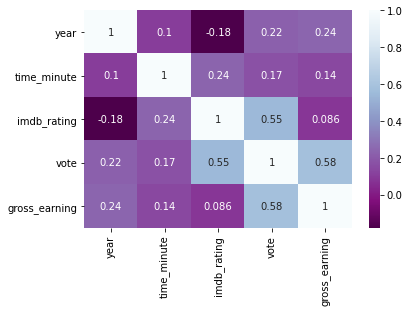

In [18]:
sns.heatmap(df.corr(),cmap="BuPu_r",annot=True) 

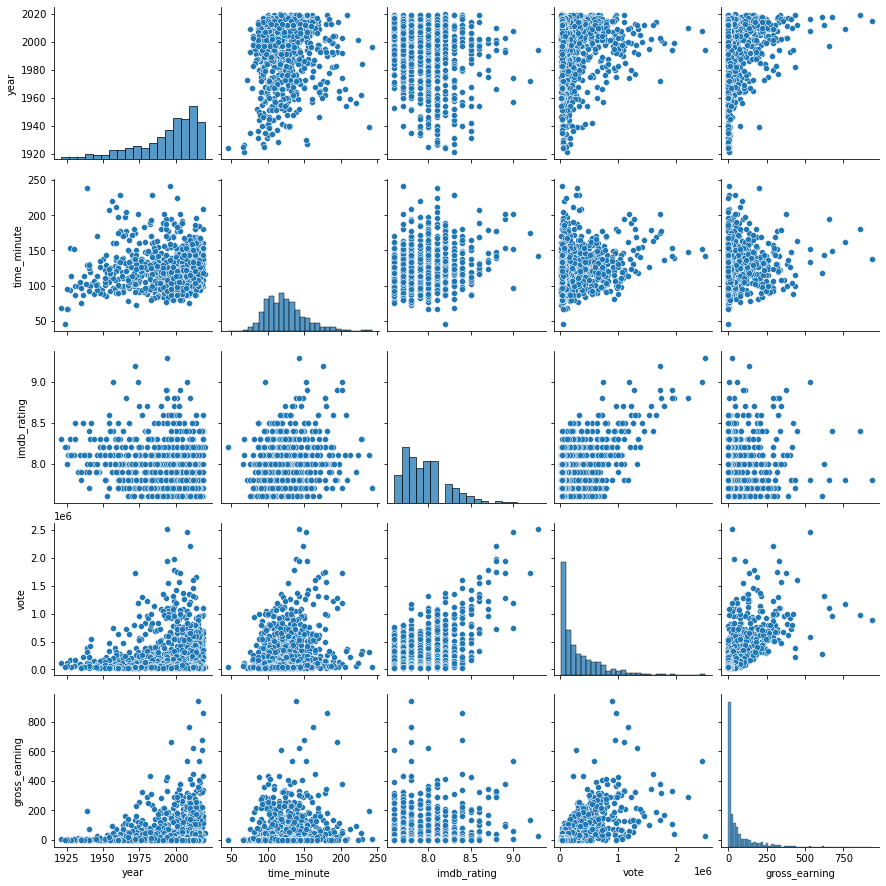

In [19]:
sns.pairplot(df)

# Modeling

In [20]:
X=df[['imdb_rating','year','time_minute','vote']]
y=df.gross_earning

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# LinearRegression

In [22]:
lr= LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [23]:
lr.score(X_train, y_train)

0.39637419114094785

In [24]:
lr.score(X_val, y_val)

0.37091403113269517

In [25]:
mean_absolute_error(predictions,y_test)

NameError: name 'predictions' is not defined

In [ ]:
y_predicted=lr.predict(X_test)

In [ ]:
fig, ax = plt.subplots(nrows=1, )
ax.scatter(y_predicted, y_test, edgecolors=(1, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b--', lw=5)
ax.set_xlabel('gross' )
ax.set_ylabel('rating')
plt.show()

In [ ]:
sns.heatmap(df.corr(),cmap="BuPu_r",annot=True) 

In [ ]:
sns.pairplot(df)

In [ ]:
poly = PolynomialFeatures(degree=4)

X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly,y_train)
lr_poly.score(X_train_poly,y_train)

In [ ]:
lr_poly.score(X_test_poly,y_test)

In [ ]:
predictions = lr_poly.predict(X_test_poly)
plt.scatter(y_test, predictions, marker='x')